In [39]:
import torch
from torch import nn
import matplotlib.pyplot as plt

1. Data (preparing and loading)

Data can be almost anything.. in machine learning.

1.Excel spreadsheet
2.Images of any kind
3.Videos
4.Audio ike songs or podcasts
5.DNA
6.Text

Machine learning is a game of two parts:

1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

Spam, not spam?
multi classification (is it ramen, is it spaghetti)

What our model does:

* Start with random values (weight and bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias values we used to create the data)

This is done through two main algorithms:
1. gradient descent
2. back propogation


In [40]:
weight = 0.7
bias = 0.3
# y = a + bx
#Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [41]:
#create a train/test split
#can use sklearn train_test_split to split more randomly
train_split=int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  #Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="training data")

  #Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="testing data")

  #Are there predictions?
  if predictions is not None:
    #Plot predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="predictions")

  #show the legend
  plt.legend(prop={"size":14})


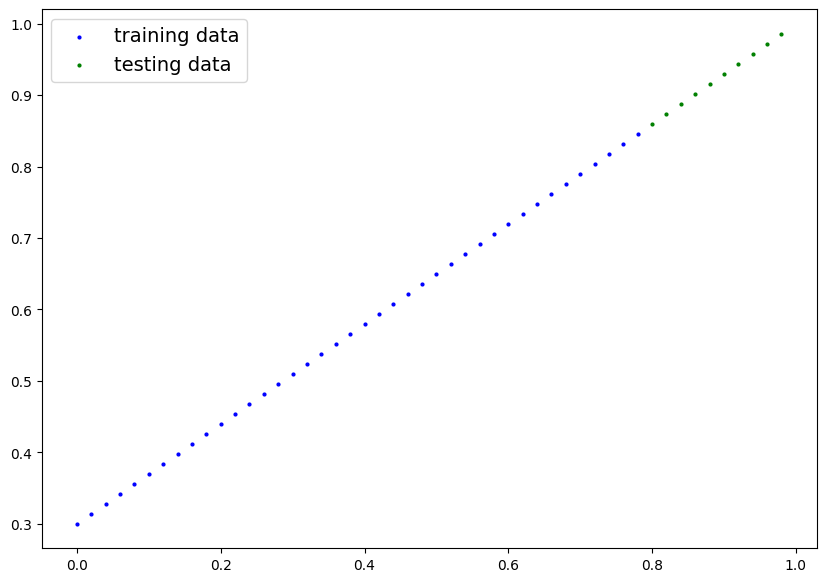

In [43]:
plot_predictions()

## 2. Build model

Our first Pytorch model

In [44]:
# Create linear regression model class

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))  
    
    #Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: #"x" is the input data
    return self.weights * x + self.bias

  



### Pytorch model building essentials

* torch.nn contains the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent.
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

In [45]:
torch.manual_seed(42)
torch.randn(1)

tensor([0.3367])

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.parameters()`

In [46]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

#Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [47]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#make prediction using `torch.inference_mode()`   predict y_test based on x_test
#when passing data through our model it will run through our forward() method


In [48]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds, y_test 

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

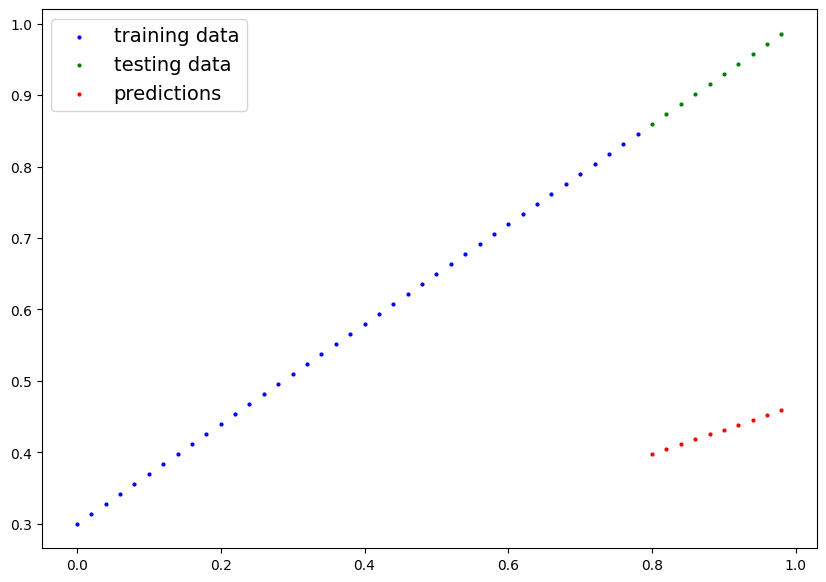

In [49]:
plot_predictions(predictions=y_preds)

### 3. Train a model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters

Or in other words from a poor representation of the data to a better representation of the data

One way to measure how poor or wrong your predictions are is to use a loss function.

* Loss function: A function to measure how wrong your model's predictions are to the ideal outputs, lower is better
* Optimizer: Takes into account the loss of a model and adjusts the model's parameters (.e.g. weight & bias)

In [50]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [51]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)


### Building a training loop (and a testing loop) in Pytorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on the data - also called forward propogation
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (backpropogation)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (gradient descent)

Epoch: 0, Loss: 0.31288138031959534, Test loss: 0.48106518387794495 |
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10, Loss: 0.1976713240146637, Test loss: 0.3463551998138428 |
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20, Loss: 0.08908725529909134, Test loss: 0.21729660034179688 |
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30, Loss: 0.053148526698350906, Test loss: 0.14464017748832703 |
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40, Loss: 0.04543796554207802, Test loss: 0.11360953003168106 |
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50, Loss: 0.04167863354086876, Test loss: 0.09919948130846024 |
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60, Loss: 0.03818932920694351, Test loss: 0.08886633068323135 |
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

Text(0.5, 0, 'Epochs')

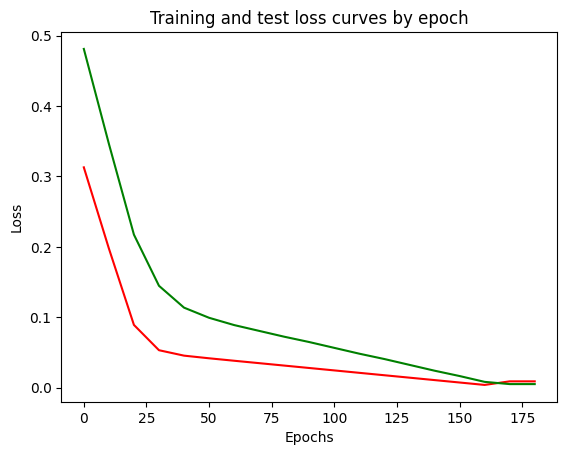

In [52]:
epoch_count = []
train_loss_values = []
test_loss_values= []

epochs = 190

for epoch in range(epochs):
  #set the model to training mode
  model_0.train() #train mode sets all parameters that require gradients to require gradients 

  #1. forward pass
  y_pred = model_0(X_train)

  #2. calculate loss
  loss = loss_fn(y_pred, y_train)

  #3. optimizer zero grad
  optimizer.zero_grad()

  #4. perform backpropogation on the loss with respect to the parameters of the model
  loss.backward()

  #5. step the optimizer (perform gradient descent)
  optimizer.step()


  model_0.eval()
  with torch.inference_mode():
    #forward pass for prediction
    y_preds = model_0(X_test)

    #calculate loss
    test_loss = loss_fn(y_preds, y_test)
    

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch}, Loss: {loss}, Test loss: {test_loss} |")
    print(model_0.state_dict())


plt.plot(epoch_count, torch.tensor(train_loss_values).numpy(), c="r", label="training loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).numpy(), c="g", label="testing loss")
plt.title("Training and test loss curves by epoch")
plt.ylabel("Loss")
plt.xlabel("Epochs")

In [53]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [54]:
with torch.inference_mode():
  #set the model to eval (test) mode 
  model_0.eval()

  #forward pass for prediction
  y_preds = model_0(X_test)

  #calculate loss
  loss = loss_fn(y_preds, y_test)
  print(loss)


tensor(0.0084)


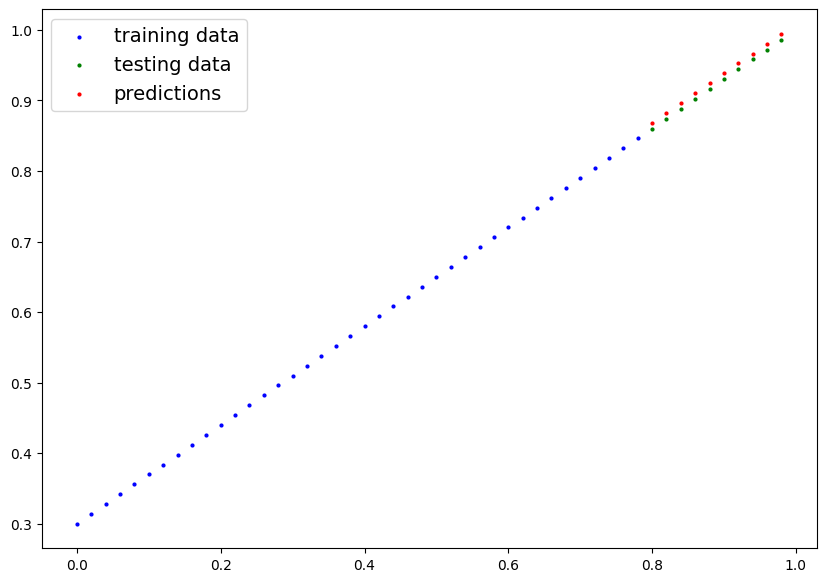

In [55]:
plot_predictions(predictions=y_preds)

# Saving a model in pytorch

There are three main methods for saving and loading pytorch models

1. `torch.save()` allows you to save a pytorch object as a python pickle file
2. `torch.load()` allows you to load a saved pytorch object
3. `torch.nn.Module.load_state_dict() - allows you to load a models saved state dictionary

In [56]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pt


In [57]:
# we saved our state_dict and not the entire model so we must create a 
#new instance of our model class and load the state dict into that
loaded_model_0 = LinearRegressionModel()

#Load saved state_Dict of model_0 into new instance
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))



<All keys matched successfully>

In [58]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [60]:
with torch.inference_mode():
  #set the model to eval (test) mode 
  loaded_model_0.eval()

  #forward pass for prediction
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [61]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Putting it all together

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

#Check PyTorch  version
torch.__version__

'2.1.2'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
#Create some data using the linear regression formula of y = weight * X + bias
weight = 0.9
bias = 0.2

#Create range values

start = 0
end = 1
step = 0.02

#create x and y (features and labels)
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.2000],
         [0.2180],
         [0.2360],
         [0.2540],
         [0.2720],
         [0.2900],
         [0.3080],
         [0.3260],
         [0.3440],
         [0.3620]]))

In [4]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

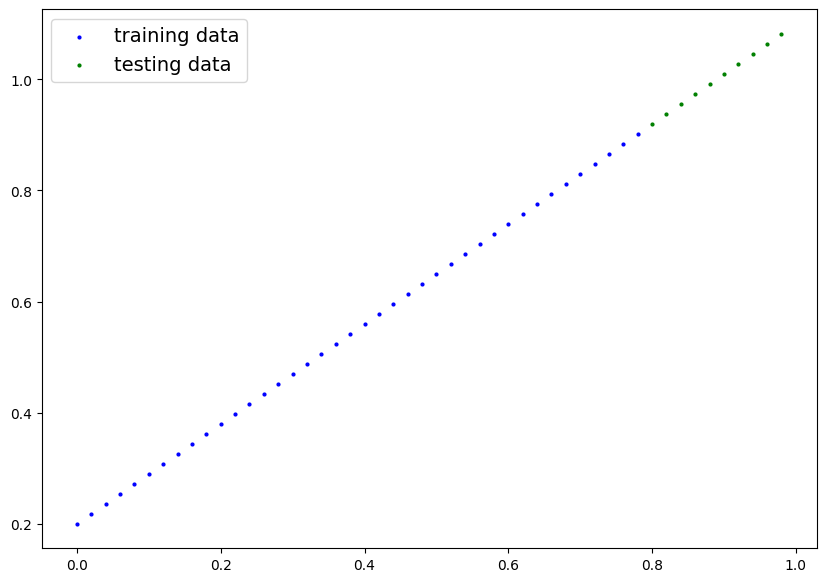

In [6]:
#Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

In [ ]:
## Building a pytorch linear model
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # self.weights = nn.Parameter(torch.randn(1,
    #                                         requires_grad=True,
    #                                         dtype=float))
    # self.bias = nn.Parameter(torch.randn(1,
    #                                      requires_grad=True,
    #                                      dtype=float))
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.linear_layer(x)
    
#Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()